In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cchakradhar","key":"8d0f8292fffc941009a1e821cc65a300"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:05<00:00, 201MB/s]
100% 812M/812M [00:05<00:00, 156MB/s]


In [12]:
!unzip -qq dogs-vs-cats.zip

In [13]:
!unzip -qq train.zip

1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a
validation sample of 500, and a test sample of 500 (like in the text). Use any technique
to reduce overfitting and improve performance in developing a network that you train
from scratch. What performance did you achieve?

As per the approach we need to train a network from scratch, from the above data i have loaded the dataset and need to import the required modules like operating system interface, high level file operations, object oriented filesystem paths etc,. are essential for working with direcrories and some other filesysytems.

In [14]:
import os, shutil, pathlib

old_dir = pathlib.Path("train")
new_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=old_dir/ fname,
                            dst=dir / fname)

make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)

**Building the model**

Here the input for this network is 3-D tensor which is images that needs to reshaped. For that we need to use the general model structure for the convnet with alternated Conv2D(with 'relu' activation) and maxpooling2D stages more due to its bigger images.

The following problem is a binary-classification either the output is determined as 'cat' or 'dog'. We need to end with dense layer and a 'sigmoid function'

First, we need to rescaling layer that are changes from [0,255] to [0,1]

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


Here we can see the dimensions of the feature maps changes in between the layers.

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

From the above we can see there are 991041 trainable params needs to optimize.

**Configuring the model**

for the compilation step we need to use the 'binary crossentropy' as loss because we ended the model with a sigmoid function.

In [17]:
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

Before we fed to the model we need to format the data into appropriate preprocess floating point tensors.
need to decode the JPEG to RGB grid of pixels, then to floating point tensors, then resize them to shared size and packing them into batches(by using batches of 32 images)

In [18]:
#image_dataset_from_directory is to setup a data pipeline that can automatically turn images to preprocessed tensors.
from tensorflow.keras.utils import image_dataset_from_directory

#this below directory it will do the subdirectories of directory and assume each one contains images from one of our classes.
#it will create and return tf.data.Dataset that inturns read, shuffle, and decode them.
train_datset = image_dataset_from_directory(
    new_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_datset = image_dataset_from_directory(
    new_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_datset = image_dataset_from_directory(
    new_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Displaying the Shapes and Labels of the Data and Dataset**

In [19]:
for data_batch, labels_batch in train_datset:
    print("data_batch_shape:", data_batch.shape)
    print("labels_batch_shape:", labels_batch.shape)
    break

data_batch_shape: (32, 180, 180, 3)
labels_batch_shape: (32,)


**Fitting the model using dataset**

let's fit the model on our dataset, here the "callbacks" are used to save the model after each epoch(iteration).

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch1.keras",
#the below arguments tell the callback to only save a new file(replace) when val_loss metric is lower than any previous time during training
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=30,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 111ms/step - loss: 0.7007 - accuracy: 0.5100 - val_loss: 0.6919 - val_accuracy: 0.5960
Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6929 - accuracy: 0.5550 - val_loss: 0.6831 - val_accuracy: 0.5540
Epoch 3/30
63/63 [==============================] - 6s 87ms/step - loss: 0.6907 - accuracy: 0.5615 - val_loss: 0.6569 - val_accuracy: 0.5870
Epoch 4/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6485 - accuracy: 0.6140 - val_loss: 0.6318 - val_accuracy: 0.6300
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6275 - accuracy: 0.6545 - val_loss: 0.6481 - val_accuracy: 0.6340
Epoch 6/30
63/63 [==============================] - 7s 108ms/step - loss: 0.5867 - accuracy: 0.6955 - val_loss: 0.6187 - val_accuracy: 0.6760
Epoch 7/30
63/63 [==============================] - 4s 61ms/step - loss: 0.5743 - accuracy: 0.7085 - val_loss: 0.7038 - val_accuracy: 0.5830
Epoch 8/30

**Displaying curves of loss and accuracy during training**

let's plot the loss and accuracy of the model within the training and validation data during training.

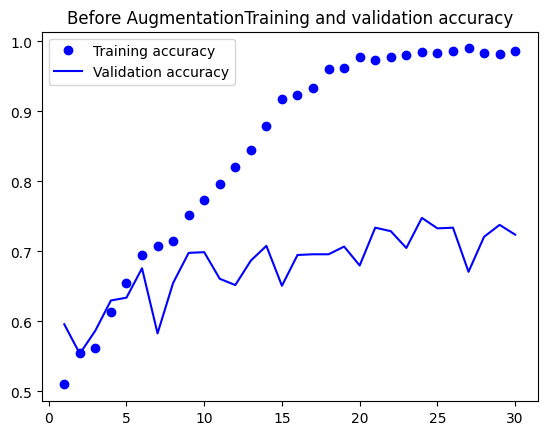

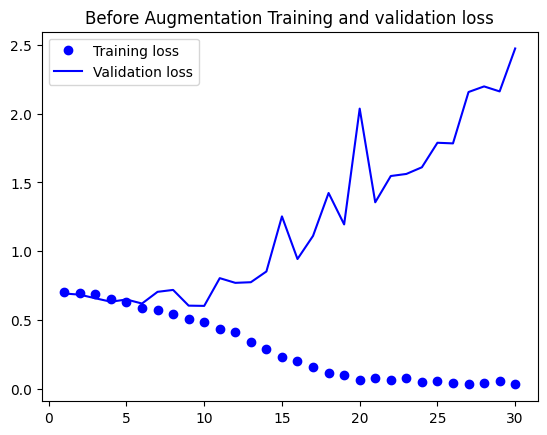

In [21]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Before AugmentationTraining and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Before Augmentation Training and validation loss")
plt.legend()
plt.show()

from the above plots are the characteristics of overfitting, the training accuracy increases linearly overtime and nearly reaches 100% whereas validation accuracy is at only 73-75%.
And the validation loss is stalls upto 10 epochs after it steadily increases where as training loss keeps decreasing linearly as training proceeds.

**Evaluating the model on test set**

Let's check test accuracy

In [22]:
test_model1 = keras.models.load_model("conv_from_scratch1.keras")
test_loss, test_acc = test_model1.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.5577 - accuracy: 0.7190
Test accuracy: 0.719


we got a test accuracy of 70% because of less training data that leads to overfitting etc,. so that we need to work with specific one to computer vision when processing images with Deep learning models called Data Augmentation

**Data Augmentation**

Defining a data augmentation stage to add an image model

In [23]:
#we are doing random flip, random rotation, random zoom
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying randomly Augmented training images**

It's just like dropout where it overcome overfitting they're inactive during inference, it will behave as same model like when we not include data augmentation and dropout.

**Defining a convnet that includes image augmentation and dropout**

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

we train the model using data augmentation and dropout to overcome overfitting we will train as many number of times----100

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=30,
    validation_data=validation_datset,
     callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 85ms/step - loss: 0.7465 - accuracy: 0.5225 - val_loss: 0.6927 - val_accuracy: 0.5230
Epoch 2/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6969 - accuracy: 0.5210 - val_loss: 0.6889 - val_accuracy: 0.5170
Epoch 3/30
63/63 [==============================] - 5s 83ms/step - loss: 0.6950 - accuracy: 0.5135 - val_loss: 0.6914 - val_accuracy: 0.5030
Epoch 4/30
63/63 [==============================] - 7s 96ms/step - loss: 0.6921 - accuracy: 0.5345 - val_loss: 0.6853 - val_accuracy: 0.5180
Epoch 5/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6733 - accuracy: 0.5900 - val_loss: 0.6907 - val_accuracy: 0.5120
Epoch 6/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6484 - accuracy: 0.6205 - val_loss: 0.6442 - val_accuracy: 0.6300
Epoch 7/30
63/63 [==============================] - 7s 101ms/step - loss: 0.6457 - accuracy: 0.6280 - val_loss: 0.6249 - val_accuracy: 0.6490
Epoch 8/30


Now let's see again the curves for loss and accuracy during training

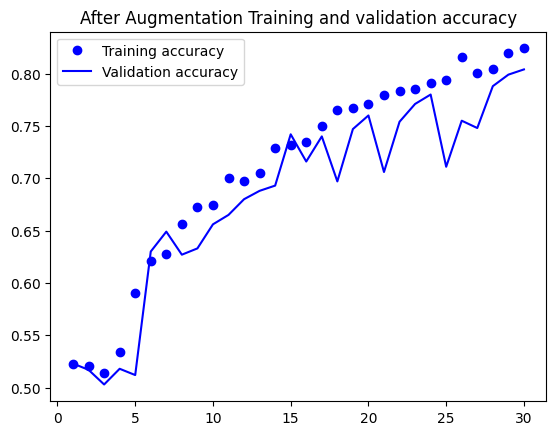

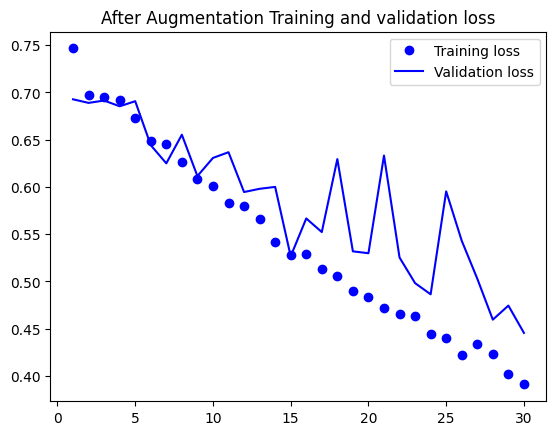

In [26]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("After Augmentation Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("After Augmentation Training and validation loss")
plt.legend()
plt.show()

**Re-evaluating the model on the test dataset**

In [27]:
test_model2 = keras.models.load_model(
    "conv_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model2.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.4280 - accuracy: 0.8130
Test accuracy: 0.813


In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=30,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 88ms/step - loss: 0.6965 - accuracy: 0.5225 - val_loss: 0.6893 - val_accuracy: 0.5370
Epoch 2/30
63/63 [==============================] - 4s 59ms/step - loss: 0.6917 - accuracy: 0.5585 - val_loss: 0.6930 - val_accuracy: 0.5330
Epoch 3/30
63/63 [==============================] - 4s 58ms/step - loss: 0.6700 - accuracy: 0.6075 - val_loss: 0.6606 - val_accuracy: 0.5880
Epoch 4/30
63/63 [==============================] - 6s 99ms/step - loss: 0.6568 - accuracy: 0.6075 - val_loss: 0.6331 - val_accuracy: 0.6460
Epoch 5/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6049 - accuracy: 0.6625 - val_loss: 0.8061 - val_accuracy: 0.6000
Epoch 6/30
63/63 [==============================] - 4s 58ms/step - loss: 0.5877 - accuracy: 0.6940 - val_loss: 0.5810 - val_accuracy: 0.6890
Epoch 7/30
63/63 [==============================] - 5s 82ms/step - loss: 0.5686 - accuracy: 0.7020 - val_loss: 0.6076 - val_accuracy: 0.6770
Epoch 8/30
6

In [30]:
test_model2 = keras.models.load_model(
    "conv_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model2.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.5321 - accuracy: 0.7450
Test accuracy: 0.745


Using Image Augmentation and Dropout method

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Here a new convnet that includes both image augmentation and dropout

In [32]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=30,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 11s 96ms/step - loss: 0.6970 - accuracy: 0.4915 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 58ms/step - loss: 0.6938 - accuracy: 0.5020 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 0.6902 - accuracy: 0.5435 - val_loss: 0.6759 - val_accuracy: 0.5900
Epoch 4/30
63/63 [==============================] - 7s 109ms/step - loss: 0.6788 - accuracy: 0.5700 - val_loss: 0.6722 - val_accuracy: 0.5760
Epoch 5/30
63/63 [==============================] - 4s 59ms/step - loss: 0.6681 - accuracy: 0.6055 - val_loss: 0.6649 - val_accuracy: 0.5940
Epoch 6/30
63/63 [==============================] - 6s 85ms/step - loss: 0.6464 - accuracy: 0.6180 - val_loss: 0.6449 - val_accuracy: 0.6230
Epoch 7/30
63/63 [==============================] - 6s 90ms/step - loss: 0.6259 - accuracy: 0.6400 - val_loss: 0.6377 - val_accuracy: 0.6530
Epoch 8/30


Evaluating the model on the test set

In [34]:
test_model2 = keras.models.load_model(
    "conv_from_scratch_with_augmentation_dropout.keras")
test_loss, test_acc = test_model2.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 30ms/step - loss: 0.3819 - accuracy: 0.8370
Test accuracy: 0.837


2. Increase your training sample size. You may pick any amount. Keep the validation and
test samples the same as above. Optimize your network (again training from scratch).
What performance did you achieve?

Here i am increasing the samples to 8000 and the model performance needs to be evaluated.

The technique here i am using data augmentation and dropout due to the performance was high based on the previous models by using this.

In [35]:
make_subset("train2", start_index=1000, end_index=8000)

train_dataset_2 = image_dataset_from_directory(
    new_dir / "train2",
    image_size=(180, 180),
    batch_size=32)

Found 14000 files belonging to 2 classes.


New convnet that includes both image augmentation and dropout

In [36]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training a reglularized convnet

In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_2,
    epochs=30,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/30
438/438 [==============================] - 26s 52ms/step - loss: 0.6673 - accuracy: 0.5828 - val_loss: 0.5957 - val_accuracy: 0.7140
Epoch 2/30
438/438 [==============================] - 24s 54ms/step - loss: 0.5509 - accuracy: 0.7215 - val_loss: 0.5175 - val_accuracy: 0.7290
Epoch 3/30
438/438 [==============================] - 24s 55ms/step - loss: 0.4690 - accuracy: 0.7779 - val_loss: 0.4410 - val_accuracy: 0.7910
Epoch 4/30
438/438 [==============================] - 23s 52ms/step - loss: 0.3968 - accuracy: 0.8217 - val_loss: 0.4998 - val_accuracy: 0.7720
Epoch 5/30
438/438 [==============================] - 25s 55ms/step - loss: 0.3335 - accuracy: 0.8546 - val_loss: 0.3691 - val_accuracy: 0.8340
Epoch 6/30
438/438 [==============================] - 23s 51ms/step - loss: 0.2815 - accuracy: 0.8814 - val_loss: 0.3567 - val_accuracy: 0.8550
Epoch 7/30
438/438 [==============================] - 25s 56ms/step - loss: 0.2422 - accuracy: 0.8959 - val_loss: 0.3797 - val_accuracy:

Evaluating the model with test set

In [38]:
test_model3 = keras.models.load_model(
    "conv_from_scratch1.keras")
test_loss, test_acc = test_model3.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.2946 - accuracy: 0.9030
Test accuracy: 0.903


3. Now change your training sample so that you achieve better performance than those
from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous
steps. The objective is to find the ideal training sample size to get best prediction
results.

Increased the samples from 8000 to 10000 in order to check the efficiency of the model.

In [39]:
make_subset("train_3", start_index=1000, end_index=10000)

train_dataset_3 = image_dataset_from_directory(
    new_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)

Found 18000 files belonging to 2 classes.


Model Building with both Image augmentation and dropout

new convnet that includes both image augmentation and dropout

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch_test1.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset_2,
    epochs=25,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/25
438/438 [==============================] - 27s 57ms/step - loss: 0.6595 - accuracy: 0.5914 - val_loss: 0.6023 - val_accuracy: 0.6850
Epoch 2/25
438/438 [==============================] - 23s 52ms/step - loss: 0.5421 - accuracy: 0.7316 - val_loss: 0.7450 - val_accuracy: 0.6050
Epoch 3/25
438/438 [==============================] - 25s 57ms/step - loss: 0.4407 - accuracy: 0.7956 - val_loss: 0.4489 - val_accuracy: 0.7950
Epoch 4/25
438/438 [==============================] - 25s 55ms/step - loss: 0.3680 - accuracy: 0.8350 - val_loss: 0.4123 - val_accuracy: 0.8320
Epoch 5/25
438/438 [==============================] - 24s 53ms/step - loss: 0.3038 - accuracy: 0.8701 - val_loss: 0.3439 - val_accuracy: 0.8510
Epoch 6/25
438/438 [==============================] - 25s 56ms/step - loss: 0.2429 - accuracy: 0.8995 - val_loss: 0.3424 - val_accuracy: 0.8780
Epoch 7/25
438/438 [==============================] - 25s 55ms/step - loss: 0.1961 - accuracy: 0.9194 - val_loss: 0.5182 - val_accuracy:

Evaluating the model with test set

In [42]:
test_model4 = keras.models.load_model(
    "conv_from_scratch_test1.keras")
test_loss, test_acc = test_model4.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.3098 - accuracy: 0.8840
Test accuracy: 0.884


with dropout

In [43]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="conv_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset_2,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
438/438 [==============================] - 30s 53ms/step - loss: 0.6777 - accuracy: 0.5608 - val_loss: 0.6372 - val_accuracy: 0.6330
Epoch 2/20
438/438 [==============================] - 23s 52ms/step - loss: 0.5835 - accuracy: 0.6911 - val_loss: 0.5352 - val_accuracy: 0.7340
Epoch 3/20
438/438 [==============================] - 26s 58ms/step - loss: 0.4918 - accuracy: 0.7659 - val_loss: 0.4132 - val_accuracy: 0.8090
Epoch 4/20
438/438 [==============================] - 24s 53ms/step - loss: 0.4067 - accuracy: 0.8130 - val_loss: 0.3892 - val_accuracy: 0.8100
Epoch 5/20
438/438 [==============================] - 23s 52ms/step - loss: 0.3437 - accuracy: 0.8489 - val_loss: 0.6646 - val_accuracy: 0.7300
Epoch 6/20
438/438 [==============================] - 24s 55ms/step - loss: 0.2996 - accuracy: 0.8723 - val_loss: 0.4283 - val_accuracy: 0.8140
Epoch 7/20
438/438 [==============================] - 29s 65ms/step - loss: 0.2544 - accuracy: 0.8940 - val_loss: 0.2669 - val_accuracy:

evaluating the model with test set

In [45]:
test_model = keras.models.load_model(
    "conv_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.2562 - accuracy: 0.8920
Test accuracy: 0.892


4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in
Steps 2 and 3 for the pretrained network may be the same or different from those using
the network where you trained from scratch. Again, use any and all optimization
techniques to get best performance

**Pre-training model--1000 training samples**

Here install and freezing the VGG16 convolution base

In [46]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


Let's get the summary of the convbase.

In [47]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Feature extraction with data augmentation**

In [48]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

**Adding a data augmentation and a classifier to the convnet base.**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
   train_datset,
   epochs=50,
   validation_data=validation_datset,
   callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6904 - accuracy: 0.5285 - val_loss: 0.6843 - val_accuracy: 0.5320
Epoch 2/50
63/63 [==============================] - 4s 58ms/step - loss: 0.6855 - accuracy: 0.5565 - val_loss: 0.6706 - val_accuracy: 0.5720
Epoch 3/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6829 - accuracy: 0.5840 - val_loss: 0.6654 - val_accuracy: 0.5760
Epoch 4/50
63/63 [==============================] - 6s 83ms/step - loss: 0.6751 - accuracy: 0.6070 - val_loss: 0.6529 - val_accuracy: 0.5970
Epoch 5/50
63/63 [==============================] - 4s 59ms/step - loss: 0.6489 - accuracy: 0.6170 - val_loss: 0.6784 - val_accuracy: 0.6130
Epoch 6/50
63/63 [==============================] - 6s 85ms/step - loss: 0.6519 - accuracy: 0.6265 - val_loss: 0.6431 - val_accuracy: 0.6410
Epoch 7/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6595 - accuracy: 0.6235 - val_loss: 0.6400 - val_accuracy: 0.6540
Epoch 8/50
63

**Plotting the curves for loss and accuracy during training**

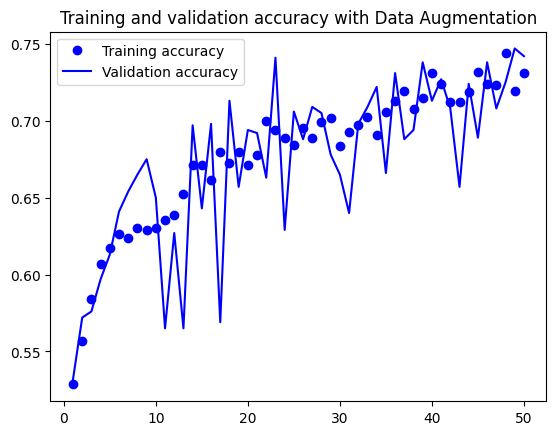

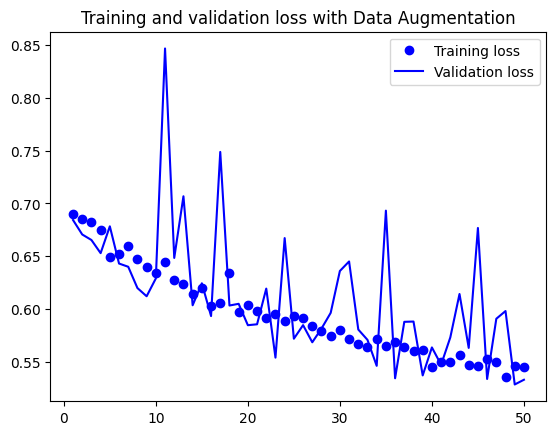

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy with Data Augmentation")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss with Data Augmentation")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model5 = keras.models.load_model("convnet_from_scratch_augmentation.keras")
test_loss, test_acc = test_model5.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 53ms/step - loss: 0.5003 - accuracy: 0.7650
Test accuracy: 0.765


**Leveraging a Pretrained model**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels** by calling predict() method of the convolution base without Data Augmentation

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_datset)
val_features, val_labels = get_features_and_labels(validation_datset)
test_features, test_labels = get_features_and_labels(test_datset)

1/1 [==============================] - 0s 24ms/step


**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 20.7716 - accuracy: 0.9265 - val_loss: 6.5151 - val_accuracy: 0.9570
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 3.1361 - accuracy: 0.9780 - val_loss: 5.9588 - val_accuracy: 0.9640
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1.5683 - accuracy: 0.9835 - val_loss: 6.9548 - val_accuracy: 0.9680
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 0.7939 - accuracy: 0.9915 - val_loss: 6.3243 - val_accuracy: 0.9650
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 0.2789 - accuracy: 0.9940 - val_loss: 9.3879 - val_accuracy: 0.9510
Epoch 6/20
63/63 [==============================] - 1s 12ms/step - loss: 0.5762 - accuracy: 0.9925 - val_loss: 6.6592 - val_accuracy: 0.9680
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.9676 - accuracy: 0.9945 - val_loss: 6.5832 - val_accuracy: 0.9730
Epoch 8/20
63/63

**Plotting the results**

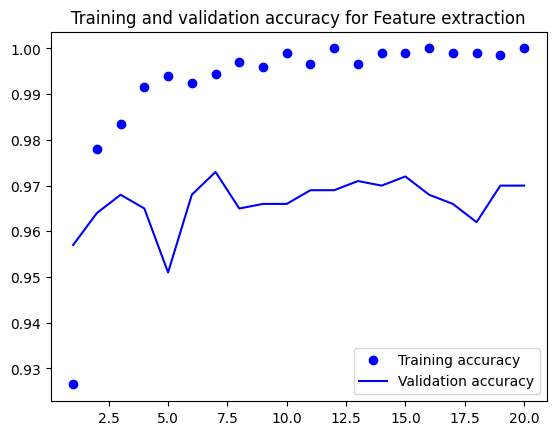

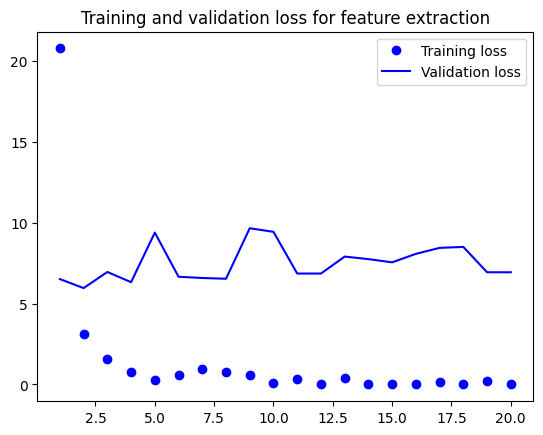

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for Feature extraction")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss for feature extraction")
plt.legend()
plt.show()

In [61]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers

In [49]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
 layer.trainable = False

**Fine tuning a model**

In [75]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In above code we use 'lambda' function make sure that preprocessing function is correctly applied with allowing serialization

**Training the regularized network**

In [76]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_datset,
    epochs=20,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 13s 141ms/step - loss: 7.0957 - accuracy: 0.6540 - val_loss: 1.7090 - val_accuracy: 0.8900
Epoch 2/20
63/63 [==============================] - 10s 148ms/step - loss: 4.6842 - accuracy: 0.7475 - val_loss: 1.2454 - val_accuracy: 0.9140
Epoch 3/20
63/63 [==============================] - 9s 147ms/step - loss: 3.4183 - accuracy: 0.7955 - val_loss: 0.7474 - val_accuracy: 0.9420
Epoch 4/20
63/63 [==============================] - 10s 156ms/step - loss: 3.2694 - accuracy: 0.8110 - val_loss: 0.6005 - val_accuracy: 0.9570
Epoch 5/20
63/63 [==============================] - 11s 158ms/step - loss: 2.9622 - accuracy: 0.8305 - val_loss: 0.5358 - val_accuracy: 0.9620
Epoch 6/20
63/63 [==============================] - 12s 178ms/step - loss: 2.6729 - accuracy: 0.8395 - val_loss: 0.5813 - val_accuracy: 0.9620
Epoch 7/20
63/63 [==============================] - 11s 164ms/step - loss: 2.5039 - accuracy: 0.8545 - val_loss: 0.5217 - val_accuracy: 0.9660


Plotting the curves of loss and accuracy during training for fine-tuning model

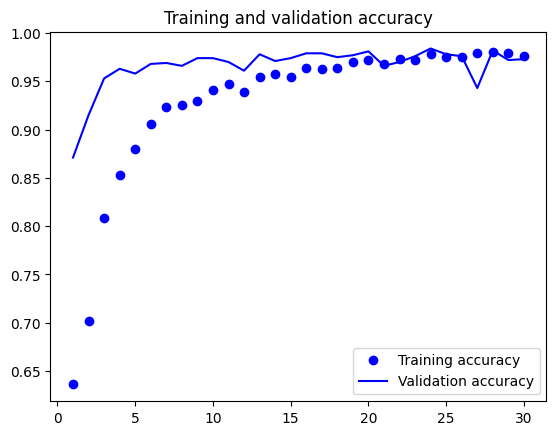

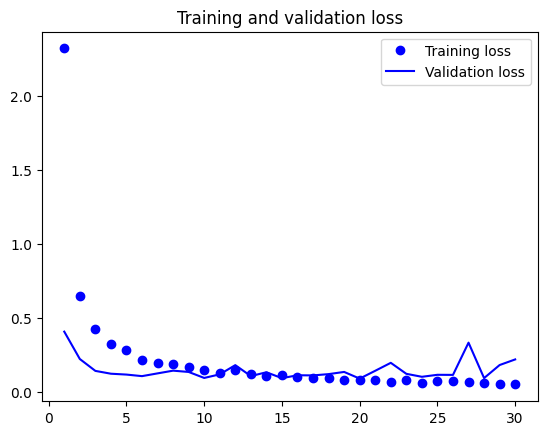

In [52]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the test set for fine-tuning

In [77]:
model = keras.models.load_model("fine_tuning.keras", safe_mode=False)
test_loss, test_acc = model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 87ms/step - loss: 0.8877 - accuracy: 0.9570
Test accuracy: 0.957


'safe_mode'= False indicates that we can load the model successfully

**Pre-trianed model-8000 Training samples**

same as we did above by install and freezing the VGG16 conv base.

In [78]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Fine tuning the pretrained model by freezing the layers**

In [79]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**By adding of augmentation and classifier to conv base**

In [80]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_2,
    epochs=10,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/10
438/438 [==============================] - 61s 120ms/step - loss: 1.1343 - accuracy: 0.8679 - val_loss: 0.1446 - val_accuracy: 0.9590
Epoch 2/10
438/438 [==============================] - 53s 120ms/step - loss: 0.1742 - accuracy: 0.9376 - val_loss: 0.1231 - val_accuracy: 0.9700
Epoch 3/10
438/438 [==============================] - 53s 120ms/step - loss: 0.1243 - accuracy: 0.9574 - val_loss: 0.1230 - val_accuracy: 0.9770
Epoch 4/10
438/438 [==============================] - 55s 124ms/step - loss: 0.1156 - accuracy: 0.9611 - val_loss: 0.1010 - val_accuracy: 0.9780
Epoch 5/10
438/438 [==============================] - 54s 122ms/step - loss: 0.0915 - accuracy: 0.9669 - val_loss: 0.1190 - val_accuracy: 0.9750
Epoch 6/10
438/438 [==============================] - 52s 118ms/step - loss: 0.0902 - accuracy: 0.9715 - val_loss: 0.1281 - val_accuracy: 0.9810
Epoch 7/10
438/438 [==============================] - 54s 123ms/step - loss: 0.0762 - accuracy: 0.9734 - val_loss: 0.1525 - val_ac

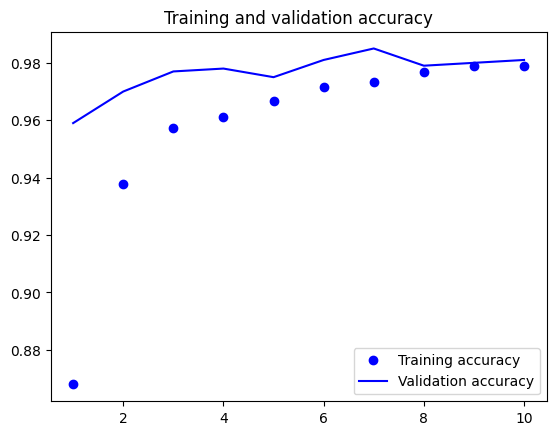

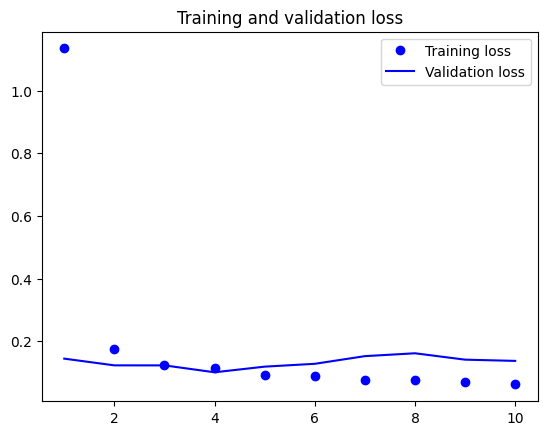

In [82]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**evaluating the model with test set**

In [81]:
model = keras.models.load_model("fine_tuning2.keras", safe_mode = False)
test_loss, test_acc = model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 87ms/step - loss: 0.1036 - accuracy: 0.9820
Test accuracy: 0.982


**Pre-trained model with 10000 samples by install and freezing the VGG16 comv base**

In [83]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Fine tuning the pretrained model and freezing the layers except last one**

In [84]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**By adding augmentation and classifier to the conv base**

In [85]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_2,
    epochs=10,
    validation_data=validation_datset,
    callbacks=callbacks)

Epoch 1/10
438/438 [==============================] - 52s 115ms/step - loss: 1.0063 - accuracy: 0.8885 - val_loss: 0.1733 - val_accuracy: 0.9680
Epoch 2/10
438/438 [==============================] - 51s 117ms/step - loss: 0.1899 - accuracy: 0.9421 - val_loss: 0.1292 - val_accuracy: 0.9730
Epoch 3/10
438/438 [==============================] - 53s 120ms/step - loss: 0.1316 - accuracy: 0.9536 - val_loss: 0.1137 - val_accuracy: 0.9700
Epoch 4/10
438/438 [==============================] - 52s 119ms/step - loss: 0.1079 - accuracy: 0.9624 - val_loss: 0.1309 - val_accuracy: 0.9810
Epoch 5/10
438/438 [==============================] - 50s 114ms/step - loss: 0.0926 - accuracy: 0.9690 - val_loss: 0.1270 - val_accuracy: 0.9750
Epoch 6/10
438/438 [==============================] - 51s 116ms/step - loss: 0.0856 - accuracy: 0.9726 - val_loss: 0.1343 - val_accuracy: 0.9770
Epoch 7/10
438/438 [==============================] - 51s 117ms/step - loss: 0.0834 - accuracy: 0.9721 - val_loss: 0.1231 - val_ac

**Plotting the curves for loss and accuracy during training for fine tuning **

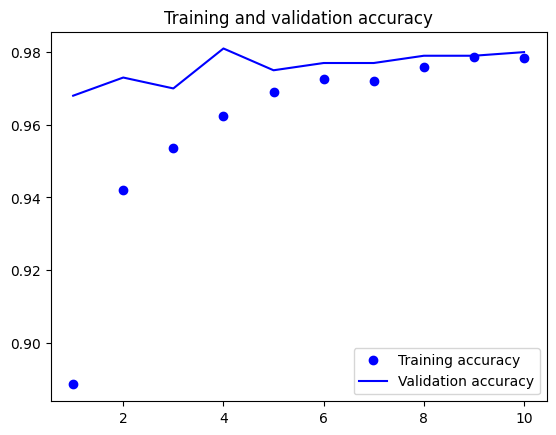

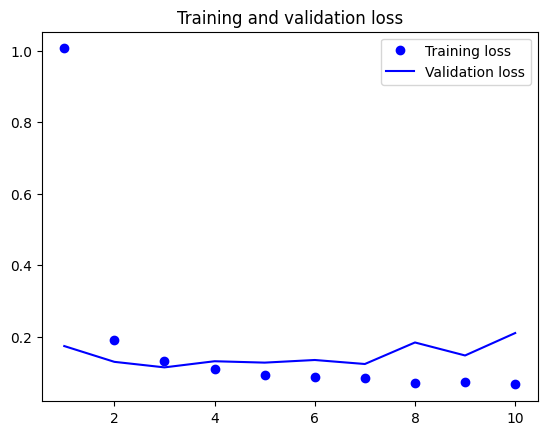

In [86]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model with test set**

In [87]:
model = keras.models.load_model("fine_tuning3.keras", safe_mode = False)
test_loss, test_acc = model.evaluate(test_datset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 87ms/step - loss: 0.1203 - accuracy: 0.9760
Test accuracy: 0.976
